In [30]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from pylab import title, show
from scipy.constants import e, c, m_e, h, alpha, hbar
from scipy.signal import hilbert

##### Initial Parameters

In [61]:
#LASER
lambda_0 = 800e-9 #laser wavelength in m
FWHM = 8.5e-6 #Full width at  half max of the gaussian laser
w0 = 60.e-6 
ctau = 10.e-6
z0 = 0.e-6
zf = 500.e-6
a0 = 2. #The peak amplitude of the laser

#GAS
initial_energy = 0e3 #initial energy of the ionized electrons (in eV)
element = 'N' # Element that is used fo ionization injection (string, use the shortcut, f.e. 'N' for nitrogen)

##### Ionization energies

In [62]:
if element == 'N':
	U_G = [14.534,29.600,47.449,77.473,97.890,552.070,667.045]
elif element == 'Ar':
	U_G = [15.760,27.629,40.742,59.812,75.017,91.009,124.319,143.462,422.448,478.684,\
			538.963,618.260,686.104,755.742,854.772,918.026,4120.887,4426.228]
elif element == 'Kr':
	U_G = [14.000,24.360,26.949,52.547,64.673,78.458,111.001,125.802,230.854,\
			268.227,307.819,350.312,390.733,446.700,492.303,541.015,591.800,640.512,785.612,833.287,\
			884.072,936.930,998.079,1050.937,1151.471,1205.261,2927,907,3069.897,3227.434,3380.826]
else:
	print("Choose an available element for ionization injection")

##### Constants and Parameters

In [63]:
#Physical constants
lambda_c = h/(m_e * c) #compton wavelength
U_H = 13.6 #ionization potential of hydrogen in eV
epsilon_0 = 8.854e-12 #Vacuum permittivity

#Other parameters
k_0 = 1/lambda_0 #wave number of the laser
E_k = (1/e)*k_0*(c**2)*m_e #laser energy
omega_0 = c*k_0 #laser frequency
energy = initial_energy*e 

##### Laser

In [64]:
def gaussian_profile(max_a, z, r, t, w0, ctau, z0, zf, k_0):

    # Calculate the Rayleigh length

    zr = 0.5*k_0*w0**2
    inv_zr = 1./zr
    inv_ctau2 = 1./ctau**2
    
    
    # Diffraction and stretch_factor
    diffract_factor = 1. - 1j*(z-zf)*inv_zr
    stretch_factor = 1.
    # Calculate the argument of the complex exponential
    exp_argument = 1j*k_0*( c*t + z0 - z ) \
        - r**2 / (w0**2 * diffract_factor) \
        - 1./stretch_factor * inv_ctau2 * ( c*t  + z0 - z )**2
    # Get the transverse profile
    profile_Eperp = np.exp(exp_argument) \
        / ( diffract_factor * stretch_factor**0.5 )
    
    return(max_a * profile_Eperp.real )

def gauss_laser(max_a,FWHM,z):
    sigma = FWHM/(np.sqrt(2*np.log(2)))
    laser_a = max_a*np.exp(-(z)**2/(2*sigma**2))
    return(laser_a)

##### Ionization

In [65]:
def ion_prob(U_i,max_a,z,r,t,w0,ctau,z0,zf,k_0, FWHM):
    
    E_gauss = gaussian_profile(max_a, z,r,t,w0,ctau,z0,zf,k_0) 
    
    amplitude = gauss_laser(max_a, FWHM, z)
        
	#Keldysh parameter
    gamma_k = (alpha/amplitude)*np.sqrt(U_i/U_H) 
    
	#Calculate the electrical field of the laser (in V/m)
    E_L = 1e2*np.sqrt(2.8e18/(lambda_0*1e6*c*epsilon_0))*E_gauss #Electrical field of the laser in V/m
	
    #Argument of the exponential function
    laser_ion = lambda_0/lambda_c * amplitude**3 *gamma_k**3 * (E_k/(np.sqrt(E_L**2)))
    tunnel_ion = (gamma_k**3 * energy)/(hbar*omega_0)
    
    #Probability
    prob = np.exp(-2/3 * (laser_ion + tunnel_ion))
    
    return(prob)

##### Plots

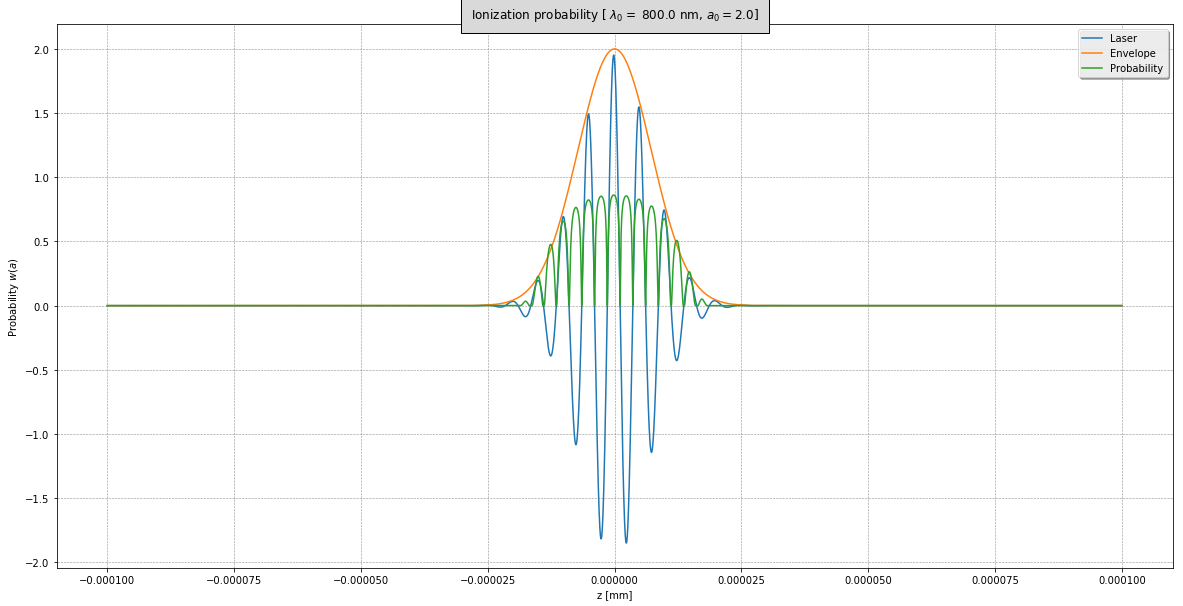

In [92]:
t = np.linspace(1.e-1,10.e-7,10000)
z= np.linspace(-100.e-6,100.e-6,10000)

invexp = lambda x: ion_prob(U_G[4],a0,x,0,0,w0,ctau,z0,zf,k_0, FWHM) 

integral = integrate.fixed_quad(invexp, -100.e-6, 100.e-6)
#integral = integrate.quadrature(ion_prob,z[0],z[len(z)-1],args=(U_G[4],a0,0,0,w0,ctau,z0,zf,k_0, FWHM),rtol=1.49e-2,maxiter=2)



### Plot the functions

# Set the size of the plot
fig, ax = plt.subplots(figsize=(20,10))

# Set the labels of the axis
plt.xlabel("z [mm]")
plt.ylabel(r"Probability $w(a)$")

ax.grid(which='major', alpha=0.8, color='grey', linestyle='--', linewidth=0.6, animated='True')
ax.grid(which='minor', alpha=0.6, color='grey', linestyle='--', linewidth=0.5, animated='True')

#Make the plots
#for i in range(0,len(U_G)): 
    #ax.plot(a0, ion_prob(U_G[i],a0), label=""+str(element)+"$^{"+str(i+1)+"+}$")
ax.plot(z, gaussian_profile(a0, z, 0, 0, w0, ctau, z0, zf, k_0), label="Laser")
ax.plot(z, gauss_laser(a0, FWHM, z), label="Envelope")
ax.plot(z, ion_prob(U_G[4],a0,z,0,0,w0,ctau,z0,zf,k_0, FWHM), label="Probability")


# Make the legend 
legend = ax.legend(loc='upper right', shadow=True)
for label in legend.get_texts():
    label.set_fontsize('medium')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
title("Ionization probability [ $\lambda_0 =$ "+str(lambda_0*1.e9)+" nm, $a_0 =$"+str(a0)+"]", bbox={'facecolor': '0.85', 'pad': 10})

plt.show()

In [93]:
max(ion_prob(U_G[4],a0,z,0,0,w0,ctau,z0,zf,k_0, FWHM))*100

86.185993338365037

In [94]:
print(integral)

(4.8855183493214383e-05, None)
